In [1]:
!pip install albumentations

  Using cached pydantic-2.10.6-py3-none-any.whl.metadata (30 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached pydantic_core-2.27.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.6 kB)
Using cached pydantic-2.10.6-py3-none-any.whl (431 kB)
Using cached pydantic_core-2.27.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.0 MB)
Using cached annotated_types-0.7.0-py3-none-any.whl (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 8.1 MB/s eta 0:00:00


In [ ]:
import segmentation_models_pytorch as smp
# import torch

model = smp.Unet(encoder_name="resnet50",  
                 encoder_weights="imagenet",  # Use pretrained weights
                 in_channels=1,  
                 classes=1,
                ) 

In [ ]:
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import os
from glob import glob
from sklearn.model_selection import train_test_split


# Get files from both datasets
image_files = sorted(glob(os.path.join("dataset/mito_data/raw/", "*.tif")))
mask_files = sorted(glob(os.path.join("dataset/mito_data/masks/", "*.tif")))


# Split the data into 80% train and 20% test

train_img_files, test_img_files, train_mask_files, test_mask_files = train_test_split(
    image_files, mask_files, test_size=0.1, random_state=42
)

len(train_img_files),len(test_img_files), len(train_mask_files), len(test_mask_files)

(25, 3, 25, 3)

In [70]:
test_img_files

['dataset/mito_data/raw/6800x-120kv-0011.tif',
 'dataset/mito_data/raw/6800x-120kv-0028.tif',
 'dataset/mito_data/raw/6800x-120kv-0010.tif']

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
import numpy as np
from PIL import Image

class CristaeDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None, mask_transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.mask_transform = mask_transform  # Separate transform for masks

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)  
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)  
        
        img = img / 255.0  # Normalize to [0, 1]
        mask = (mask > 0).astype(np.float32)  # Convert mask to binary
        
        # # Convert to PIL for torchvision transforms
        img = Image.fromarray((img * 255).astype(np.uint8))
        mask = Image.fromarray((mask * 255).astype(np.uint8))  # Keep as uint8 for transforms
      
        
        if self.transform:
            img = self.transform(img)  # Apply image transforms
        
        if self.mask_transform:
            mask = self.mask_transform(mask)  # Apply mask-specific transforms

        return img, mask



image_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),  # Convert to tensor
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST), 
    transforms.ToTensor(),
])

# Test transforms (only resizing, no augmentation)
test_image_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
])

test_mask_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor(),
])

# Datasets
train_dataset = CristaeDataset(train_img_files, train_mask_files, transform=image_transform, mask_transform=mask_transform)
test_dataset = CristaeDataset(test_img_files, test_mask_files, transform=test_image_transform, mask_transform=test_mask_transform)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [ ]:
import torch
import numpy as np

class EarlyStopping:
    
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt'):
       
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_score - self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

def train_with_early_stopping(model, train_loader, val_loader, device, num_epochs=30):
    
    # Optimizer with higher initial learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=0.5,  # Reduce LR by half
        patience=3,  # Wait 3 epochs before reducing LR
        min_lr=1e-5  # Minimum learning rate
    )
    
    
    loss_fn = torch.nn.BCEWithLogitsLoss()
    
    
    early_stopping = EarlyStopping(
        patience=5, 
        verbose=True, 
        path='best_model_checkpoint.pt'
    )
    
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        # Training
        for imgs, masks in train_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = loss_fn(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # testing 
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs, masks = imgs.to(device), masks.to(device)
                outputs = model(imgs)
                loss = loss_fn(outputs, masks)
                val_loss += loss.item()
        
       
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        
        scheduler.step(val_loss)
        
        
        early_stopping(val_loss, model)
        
        
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break
    
    # Load the best model
    model.load_state_dict(torch.load('best_model_checkpoint.pt'))
    return model


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model = train_with_early_stopping(model, train_loader, test_loader, device)

Epoch 1/30:
Train Loss: 0.5280, Val Loss: 0.5301
Validation loss decreased (inf --> 0.530121).  Saving model ...
Epoch 2/30:
Train Loss: 0.3247, Val Loss: 0.5137
Validation loss decreased (0.530121 --> 0.513670).  Saving model ...
Epoch 3/30:
Train Loss: 0.2372, Val Loss: 0.2416
Validation loss decreased (0.513670 --> 0.241589).  Saving model ...
Epoch 4/30:
Train Loss: 0.1848, Val Loss: 0.1763
Validation loss decreased (0.241589 --> 0.176278).  Saving model ...
Epoch 5/30:
Train Loss: 0.1444, Val Loss: 0.1477
Validation loss decreased (0.176278 --> 0.147739).  Saving model ...
Epoch 6/30:
Train Loss: 0.1263, Val Loss: 0.1180
Validation loss decreased (0.147739 --> 0.118012).  Saving model ...
Epoch 7/30:
Train Loss: 0.1040, Val Loss: 0.1191
EarlyStopping counter: 1 out of 5
Epoch 8/30:
Train Loss: 0.0872, Val Loss: 0.1061
Validation loss decreased (0.118012 --> 0.106118).  Saving model ...
Epoch 9/30:
Train Loss: 0.0847, Val Loss: 0.1062
EarlyStopping counter: 1 out of 5
Epoch 10/30:


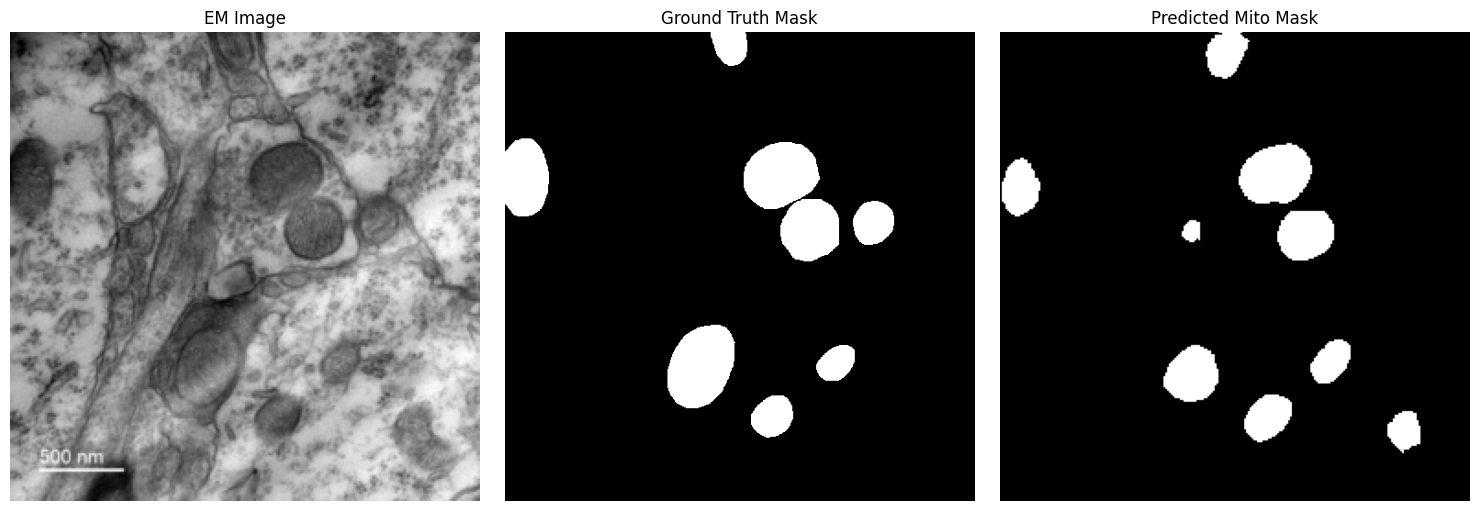

In [ ]:
import cv2
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np
import segmentation_models_pytorch as smp

TEST_IMG_NUMBER = "0028" # 11,28, 10

test_img = cv2.imread(f"dataset/mito_data/raw/6800x-120kv-{TEST_IMG_NUMBER}.tif", cv2.IMREAD_GRAYSCALE) / 255.0 #23, 18,5


eval_transform = transforms.Compose([
    transforms.ToPILImage(),             # Convert numpy array to PIL image
    transforms.Resize((256, 256)),       # Resize to 256x256 or your desired size
    transforms.ToTensor(),               # Convert to tensor
])



# Apply transformations
test_img = eval_transform(test_img)

# Add a batch dimension and send to device (cuda or cpu)
test_img = test_img.unsqueeze(0).to(device)  # Add 

ground_truth_mask = cv2.imread(f"dataset/mito_data/masks/6800x-120kv-{TEST_IMG_NUMBER}.tif", cv2.IMREAD_GRAYSCALE)
ground_truth_mask = (ground_truth_mask > 0.5).astype(np.uint8)  # Apply threshold if necessary

model.eval()
with torch.inference_mode():
    pred_mask = model(test_img).squeeze().cpu().numpy()
    pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Apply threshold

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Display the real image
real_img = test_img.squeeze().cpu() * 225.0
axes[0].imshow(real_img, cmap='gray')
axes[0].set_title("EM Image")
axes[0].axis('off')

# Display the ground truth mask
axes[1].imshow(ground_truth_mask, cmap='gray')
axes[1].set_title("Ground Truth Mask")
axes[1].axis('off')

# Display the predicted mask
axes[2].imshow(pred_mask, cmap='gray')
axes[2].set_title("Predicted Mito Mask")
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:

eval_transform = transforms.Compose([
    transforms.ToPILImage(),             # Convert numpy array to PIL image
    transforms.Resize((256, 256)),       # Resize to 256x256 or your desired size
    transforms.ToTensor(),               # Convert to tensor
])
# Apply transformations
other_img = eval_transform(test_img)

# Add a batch dimension (if necessary) and send to the device
other_img = test_img.unsqueeze(0).to("cuda")  # Add batch dimension and send to device


In [ ]:
import cv2
import numpy as np

def get_mask_properties(mask):
    mask = (mask * 255).astype(np.uint8)  # Convert to uint8 for OpenCV
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    area = sum(cv2.contourArea(cnt) for cnt in contours)  # Compute total area
    perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours)  # Compute total perimeter

    return area, perimeter

# Example usage
area, perimeter = get_mask_properties(pred_mask)
area_real, perimeter_real = get_mask_properties(ground_truth_mask)

print(f"Predicted Mask Area: {area:.2f} pixels²")
print(f"Predicted Mask Perimeter: {perimeter:.2f} pixels")

print(f"Predicted Mask Area: {area_real:.2f} pixels²")
print(f"Predicted Mask Perimeter: {perimeter_real:.2f} pixels")

Predicted Mask Area: 1392.50 pixels²
Predicted Mask Perimeter: 477.14 pixels
Predicted Mask Area: 1384.00 pixels²
Predicted Mask Perimeter: 485.73 pixels
